In [ ]:
#!pip install numba

In [2]:
import numba
import numba.cuda as cuda

import numpy as np
import matplotlib.pyplot as plt

import time

Time to run is: 
[0.17851758 0.00670314 0.00520658 0.00438881 0.0040226  0.00380468
 0.00656581 0.00336313 0.00330591 0.00315285 0.00312901 0.00537014
 0.00302362 0.00300789 0.00324368 0.00302958 0.00358891 0.00549388
 0.00306368 0.00302005 0.00352526 0.00361776 0.00544906 0.00300431
 0.00307345 0.00292706 0.00306749 0.00304174 0.00540447 0.00294209
 0.00304818 0.00294375 0.00304818 0.00561261 0.00323248 0.00306296
 0.00301147 0.00311995 0.00316811 0.0053916  0.00294471 0.00296474
 0.00307608 0.00291705 0.0053091  0.0029943  0.00309253 0.00315356
 0.00322008 0.00294232 0.00531936 0.00340414 0.00311017 0.00307107
 0.00333238 0.00525117 0.00312185 0.00296736 0.00304198 0.00296831
 0.00316954 0.00527811 0.00345492 0.00332022 0.00305438 0.00293756
 0.00544548 0.00298858 0.0031178  0.00291729 0.00308466 0.00350666
 0.0054636  0.00300312 0.00302672 0.00294971 0.00306726 0.00539327
 0.00311232 0.00295496]


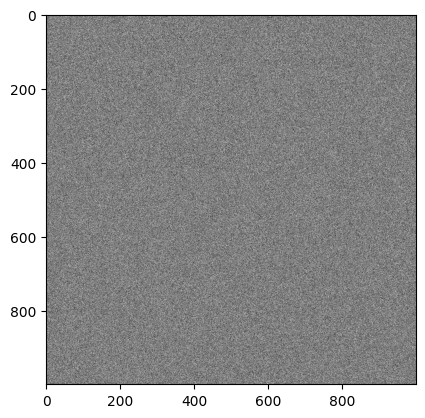

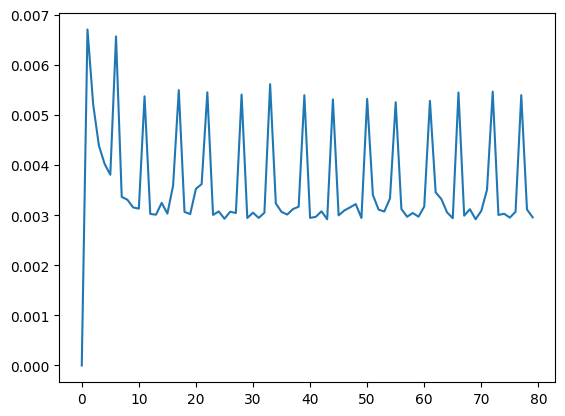

In [11]:


imageWidth = 1000
imageHeight = 1000
blockSize = 64
maxBlockSize = 80

hostData = np.random.randint(0, 255, (imageHeight, imageWidth, 3), dtype=np.uint8)

print(cuda.threadIdx.x)

@cuda.jit

#kernelName[numBlock, blockSize](args)
def grayscale(src, out):
  srcSize = src.shape[1]
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  x = tidx % srcSize
  y = tidx // srcSize

  if x < srcSize and y < srcSize:
    gray = np.uint8 ((src[x,y,0]+src[x,y, 1]+ src[x,y, 2]) / 3)
    out[x,y, 0] = out[x,y, 1] = out[x,y, 2] = gray

time_per_block_size = np.zeros(maxBlockSize)


for i in range(maxBlockSize):
  blockSize = i+1

  start_time = time.time()

  devData = cuda.to_device(hostData)
  #devData = cuda.device_array
  devOutput = cuda.device_array((imageHeight, imageWidth, 3), np.uint8)

  pixelCount = imageWidth * imageHeight
  gridSize = int(pixelCount / blockSize)

  grayscale[gridSize, blockSize](devData, devOutput)

  hostOutput = devOutput.copy_to_host()

  end_time = time.time()
  run_time = end_time-start_time
  np.append(time_per_block_size, run_time)
  time_per_block_size[blockSize-1] = run_time
  #print(run_time)

print("Time to run is: ")
print(time_per_block_size)
time_per_block_size[0] = 0

plt.imshow(hostOutput)
plt.show()
plt.plot(time_per_block_size)
plt.show()